# DeepTremor Time Series Forecasting

This notebook is a template for doing time series forecasting on the Ridgecrest dataset

In [1]:
import sys
sys.path.append("./networks/.")
sys.path.append("../utils/.")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

from utils import *
from lstm import *


/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/tensorflow/pyth

## The Ridgecrest Dataset
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [3]:
# dataset = np.load('../data/acc/compressed/full_data.npy')
dataset = np.load('../data/acc/compressed_pool/full_data.npy')

print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


35679
-0.49 7.1
35679
0.0 3.0
[8.31445749e-01 3.72105878e-01 9.15785421e+00 1.48662500e+03]
[2.000e+00 1.000e+00 1.000e+01 1.488e+03]


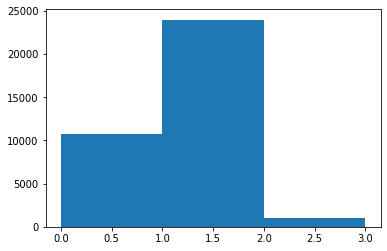

In [4]:
from sklearn.utils.class_weight import compute_class_weight

richters_path = "../data/metadata/richters.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_discrete = np.zeros_like(richters)
richters_discrete += np.where(richters >= 5., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 3., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 1., np.ones_like(richters), np.zeros_like(richters))
# richters_discrete += np.where(richters < 1., np.ones_like(richters), np.zeros_like(richters))

print(len(richters_discrete))
print(min(richters_discrete), max(richters_discrete))

class_weights = compute_class_weight('balanced', np.array(classes), richters_discrete)
print(class_weights)
# num_copies = np.round(class_weights, 0) + 1 #Add constant to ensure minimum num copies for smallest class
num_copies = np.round(class_weights, 0) + 1 #Add constant to ensure minimum num copies for smallest class

print(num_copies)
plt.hist(richters_discrete, bins=3)
plt.show()

# Try normalizing

In [5]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

An observation is recorded every centisecond. This means that, for a single minute, you will have 60000 observations. 

Given a specific sequence, let's say you want to predict the future shaking of the earthquake at the next time point. In order to make this prediction, you choose to use 10 seconds of observations. Thus, you would create a window containing the last 1000 observations to train the model..

# Parsing in the dataset

In [6]:
from sklearn.model_selection import train_test_split

past_history = 15
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)

dataset, richters_discrete = shuffle_together(dataset, richters_discrete, seed=10)

### Single-step predictions

In [15]:
STEP = 1
future_target = 1

x_train_single, y_train_single = multivariate_data_balanced(dataset[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                               richters_discrete[:TRAIN_SPLIT_IDX], num_copies,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data_balanced(dataset[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
                                               richters_discrete[TRAIN_SPLIT_IDX:], num_copies,
                                               single_step=True)

# x_single, y_single = multivariate_data(dataset,past_history,
#                                                    future_target, STEP,
#                                                richters_discrete, num_copies,
#                                                    single_step=True)

# print(y_single.shape, x_single.shape)
# x_train_single, x_val_single, y_train_single, y_val_single = train_test_split(x_single, y_single, test_size=.2, random_state=13)
print(x_train_single.shape, x_val_single.shape, y_train_single.shape, y_val_single.shape)

(2205500, 15, 15) (614680, 15, 15) (2205500, 15) (614680, 15)


In [16]:
print("Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):")
print("Train set: ", [np.sum(richters_discrete[:TRAIN_SPLIT_IDX] == i) for i in range(4)])
print("Val set: ", [np.sum(richters_discrete[TRAIN_SPLIT_IDX:] == i) for i in range(4)])


Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):
Train set:  [8560, 19193, 786, 4]
Val set:  [2168, 4778, 188, 2]


In [17]:
x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

((2205500, 15, 15), (2205500, 15), (614680, 15, 15), (614680, 15))

# Functions for visualizing data

In [7]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [8]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [11]:
plot = show_plot([x_train_single[0, :, 0], y_train_single[0, 0]], 0, 'Sample Example')
plot.show()

NameError: name 'x_train_single' is not defined

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [21]:
def baseline(history):
    return np.mean(history, axis = 0)

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/quakes/lib/python3.7/site-packages/matplotlib/pyplot.py'>

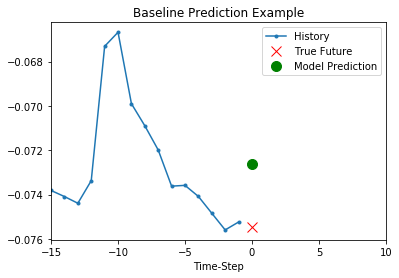

In [22]:
show_plot([x_train_single[0, :, 0], y_train_single[0, 0], baseline(x_train_single[0, :, 0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))


You will see the LSTM requires the input shape of the data it is being given.

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [23]:
single_step_model = LSTM_3(sizes = [64, 32, 32], input_shape = (15, 15), output_shape=15)

# single_step_model = tf.keras.models.Sequential()
# single_step_model.add(tf.keras.layers.LSTM(64,
#                                           return_sequences=True,
#                                           input_shape=x_train_single.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'))
# single_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
# single_step_model.add(tf.keras.layers.Dense(y_train_single.shape[-1]))

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 15)                495       
Total params: 41,711
Trainable params: 41,711
Non-trainable params: 0
_________________________________________________________________


Let's check out a sample prediction.

In [24]:
print(single_step_model.predict(x_val_single[:2]))
print(single_step_model.predict(x_val_single[:2]).shape)

[[ 0.01203055  0.00433416  0.00833954  0.00632627 -0.0011173  -0.00133331
   0.00558445 -0.00355618  0.01161457  0.00726043  0.00260414 -0.00517741
   0.00829296 -0.00218408  0.00319599]
 [ 0.01051021  0.00352306  0.00758499  0.00636573 -0.00187087 -0.00180643
   0.00514433 -0.00334579  0.01155647  0.00745466  0.00311617 -0.00490637
   0.00774241 -0.00246485  0.00283038]]
(2, 15)


In [25]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = 0.01

save_path = "./trained_models"
cur_file = "LSTM3_Balanced"
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Using TensorFlow backend.


In [26]:
EPOCHS = 10
BATCH_SIZE = 2048
single_step_history = single_step_model.fit(x_train_single, y_train_single, epochs=EPOCHS,
                                            batch_size=BATCH_SIZE,
                                            validation_data=(x_val_single, y_val_single),
                                            callbacks = callback_list)

Train on 2328128 samples, validate on 492052 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2326528/2328128 [============================>.] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.0574 - mean_squared_error: 0.0108
Epoch 00001: val_loss improved from inf to 0.05951, saving model to ./trained_models/LSTM3_Balanced.h5
2328128/2328128 [==============================] - 150s 64us/sample - loss: 0.0574 - mean_absolute_error: 0.0574 - mean_squared_error: 0.0108 - val_loss: 0.0595 - val_mean_absolute_error: 0.0595 - val_mean_squared_error: 0.0111
Epoch 2/10
2326528/2328128 [============================>.] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0090
Epoch 00002: val_loss improved from 0.05951 to 0.05687, saving model to ./trained_models/LSTM3_Balanced.h5
2328128/2328128 [==============================] - 144s 62us/sample - loss: 0.0511 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0090 - val_loss: 0.0569 - val_mean_a

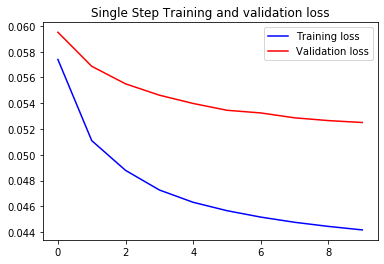

In [27]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

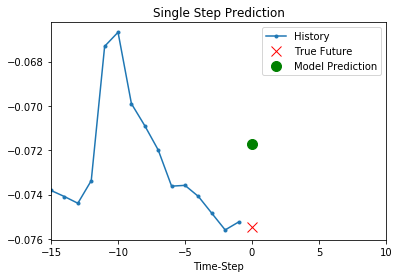

In [28]:
plot = show_plot([x_train_single[0, :, 0], y_train_single[0, 0],
                single_step_model.predict(x_train_single[0:2])[0, 0]], 0,
               'Single Step Prediction')
plot.show()

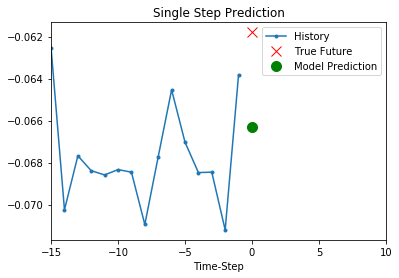

In [29]:
plot = show_plot([x_val_single[0, :, 0], y_val_single[0, 0],
                single_step_model.predict(x_val_single[0:2])[0, 0]], 0,
               'Single Step Prediction')
plot.show()

# Analyze the predictions of the model

In [30]:
y_pred = single_step_model.predict(x_test_single, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_test_single.reshape(-1)
y_pred.shape, y_true.shape

((4709760,), (4709760,))

In [31]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.5240220365727277
Max Error Score: 1.0486163244188706
Mean Absolute Error Score: 0.05281032622055712
Mean Squared Error Score: 0.009225228340991043
Median Absolute Error Score: 0.023099283722879872
R2 Score: 0.5107606943736993


In [31]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.43443139665860897
Max Error Score: 1.0735238891100718
Mean Absolute Error Score: 0.042321409713034205
Mean Squared Error Score: 0.006603191257194823
Median Absolute Error Score: 0.01629651453667895
R2 Score: 0.42351818465708924


In [37]:
# A function to reconstruct the original data
num_samples_per_quake = (x_train_single.shape[0] + x_test_single.shape[0])//dataset.shape[0]
num_quakes_in_val = x_test_single.shape[0]//num_samples_per_quake

print("Num samples per quake", num_samples_per_quake)
print("Num quakes in val", num_quakes_in_val)

Num samples per quake 74
Num quakes in val 4243


In [38]:
def recover_quake(y_pred, data, means, norms):
    y_pred = y_pred.reshape((num_quakes_in_val, -1, 15))
    data = data[-num_quakes_in_val:, past_history+future_target:]
    
    data = data*np.expand_dims(norms, 1) + np.expand_dims(means, 1)
    y_pred = y_pred*np.expand_dims(norms, 1) + np.expand_dims(means, 1)

    return data, y_pred

In [39]:
real_y_true, real_y_pred = recover_quake(y_pred, dataset[-num_quakes_in_val:], data_mean[-num_quakes_in_val:], data_var[-num_quakes_in_val:])


ValueError: cannot reshape array of size 4709760 into shape (4243,newaxis,15)

In [36]:
plt.figure()
plt.plot(real_y_true[-1, :, 0])
plt.plot(real_y_pred[-1, :, 0])
plt.show()

NameError: name 'real_y_true' is not defined

<Figure size 432x288 with 0 Axes>

In [48]:
np.mean(np.abs(real_y_true-real_y_pred))

11.350983444866534

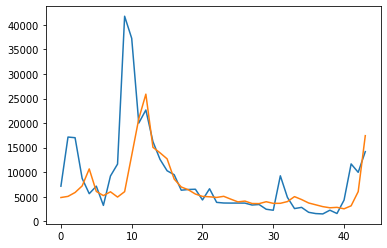

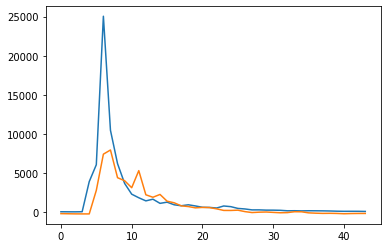

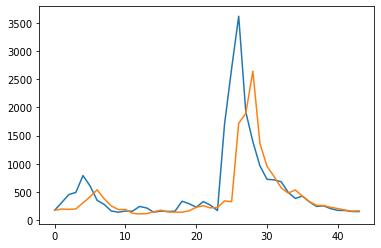

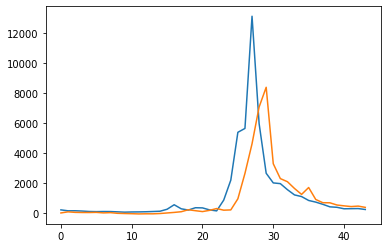

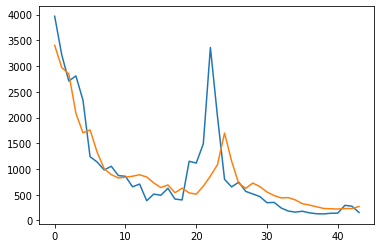

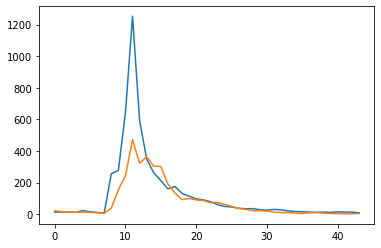

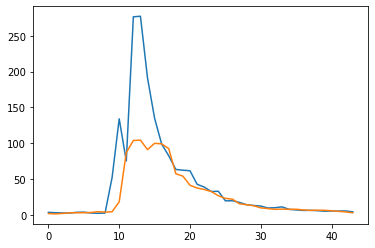

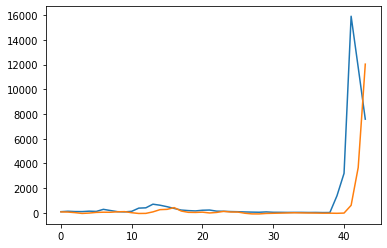

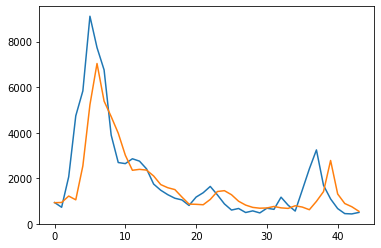

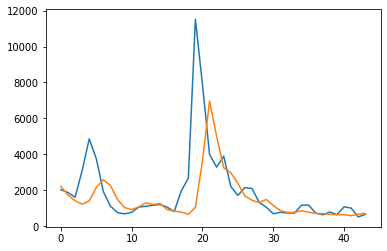

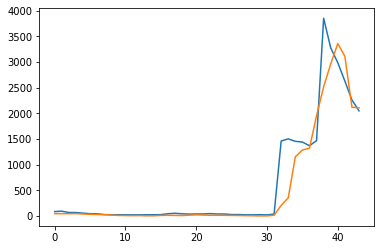

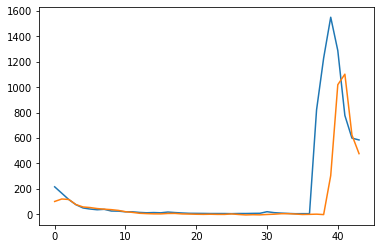

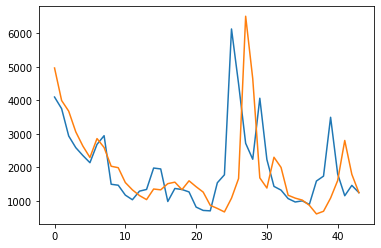

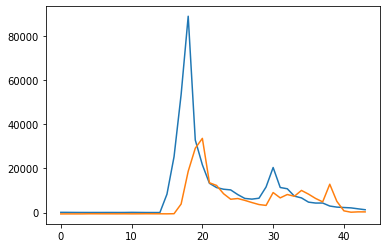

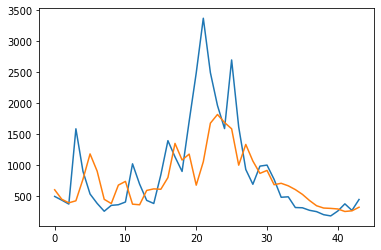

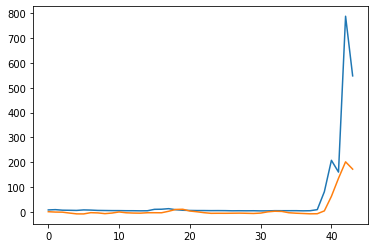

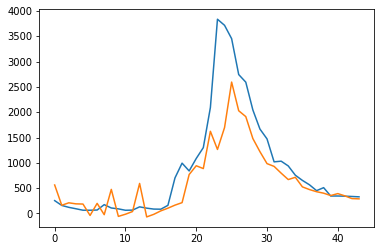

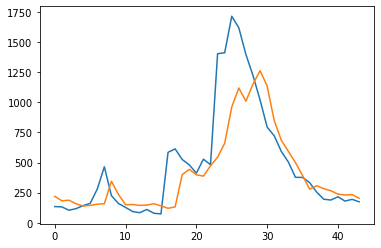

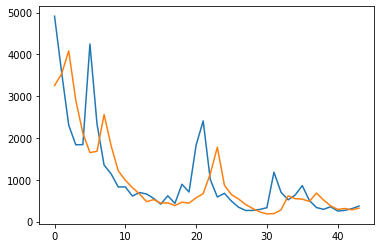

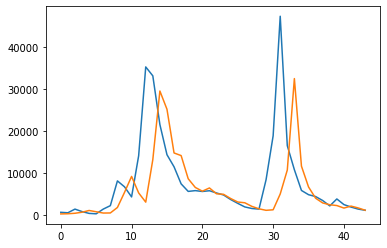

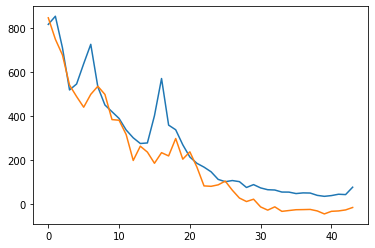

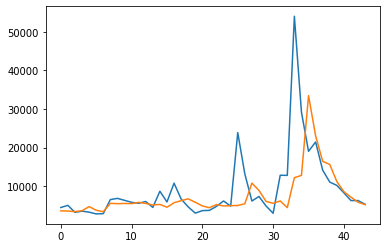

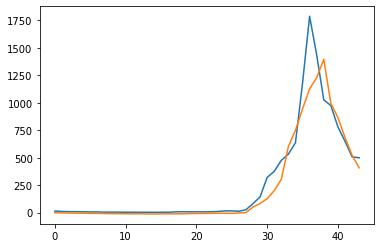

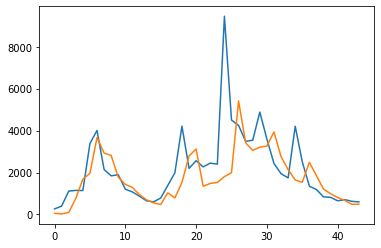

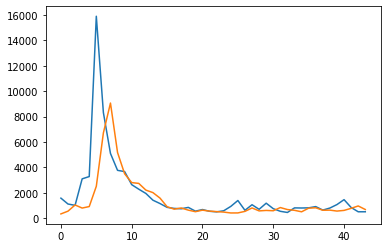

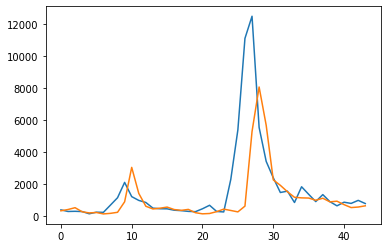

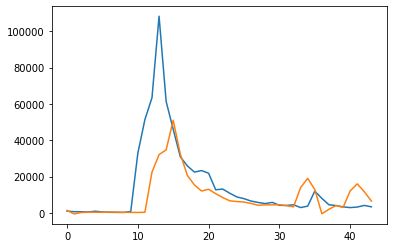

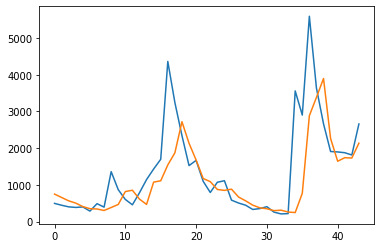

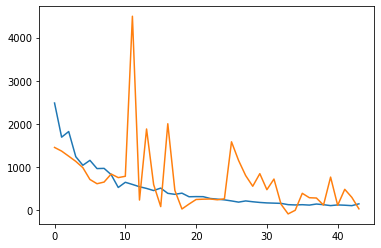

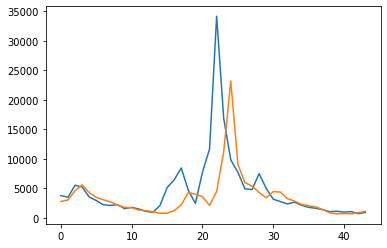

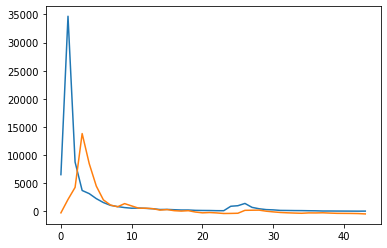

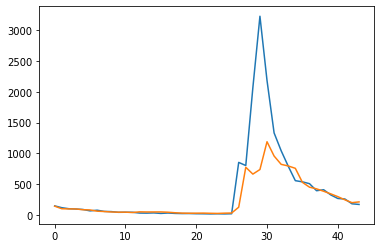

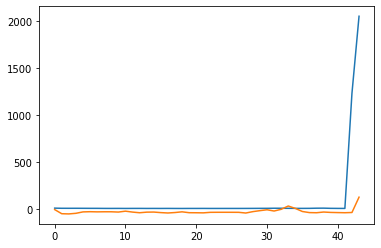

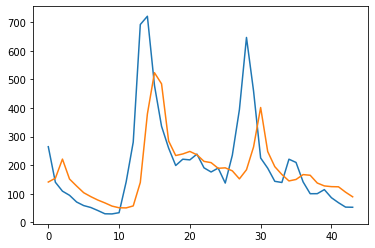

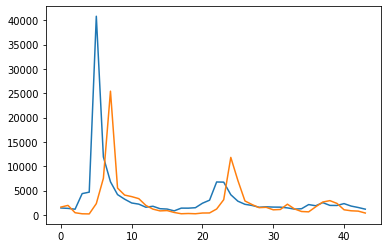

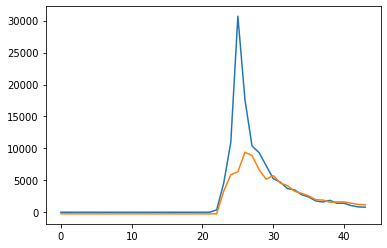

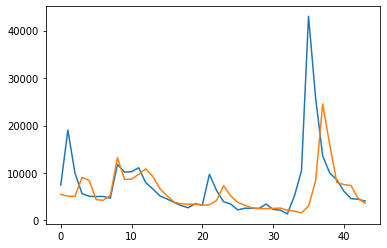

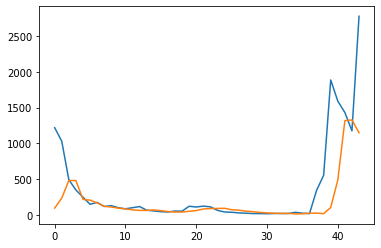

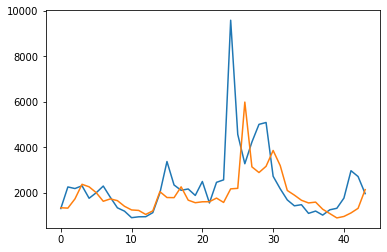

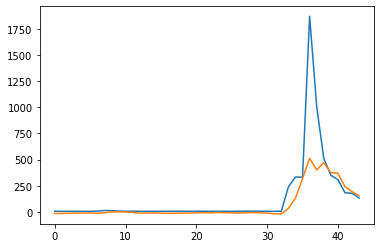

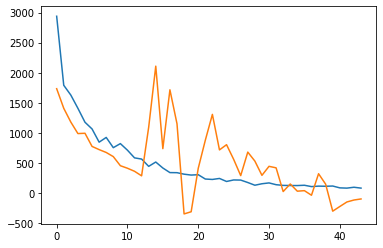

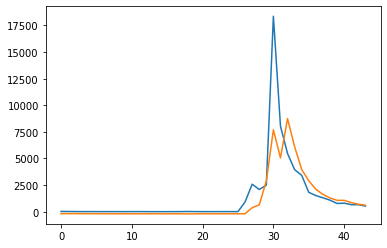

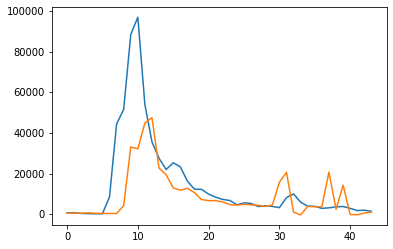

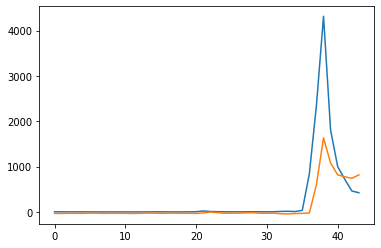

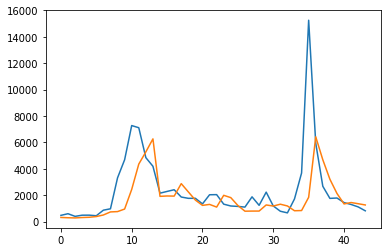

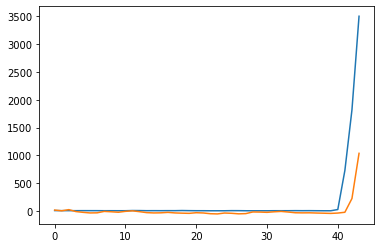

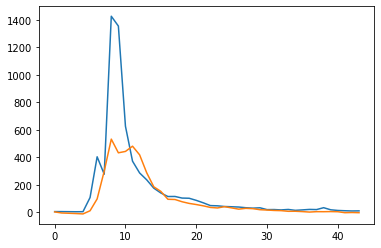

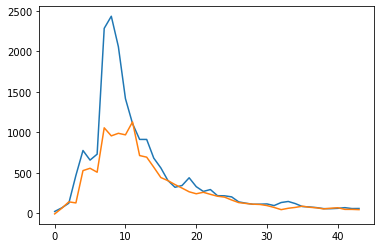

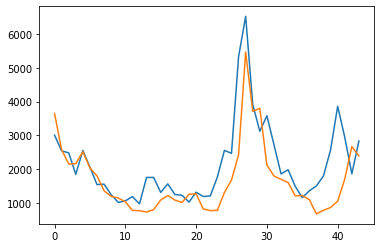

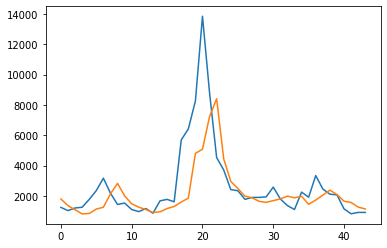

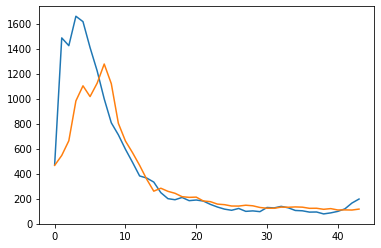

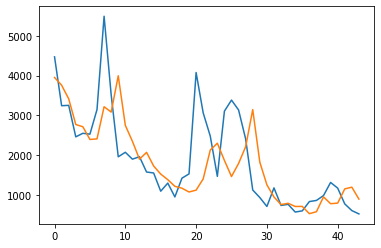

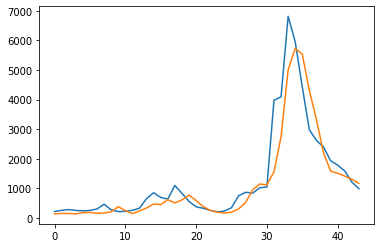

In [53]:
for idx in np.unique(np.argmax(real_y_true, axis = 0)):
    plt.figure()
    plt.plot(real_y_true[idx, :, 0])
    plt.plot(real_y_pred[idx, :, 0])
    plt.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [9]:
STEP = 1
future_target = 10

x_train_multi, y_train_multi = multivariate_data_balanced(dataset[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                               richters_discrete[:TRAIN_SPLIT_IDX], num_copies,
                                                   single_step=False)
x_val_multi, y_val_multi = multivariate_data_balanced(dataset[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
                                               richters_discrete[TRAIN_SPLIT_IDX:], num_copies,
                                               single_step=False)

#Need to reshape y to be 2d
y_train_multi = y_train_multi.reshape(y_train_multi.shape[0], -1)
y_val_multi = y_val_multi.reshape(y_val_multi.shape[0], -1)

print(x_train_multi.shape, y_train_multi.shape, x_val_multi.shape, y_val_multi.shape)

(1754375, 15, 15) (1754375, 150) (488950, 15, 15) (488950, 150)


In [10]:
print("Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):")
print("Train set: ", [np.sum(richters_discrete[:TRAIN_SPLIT_IDX] == i) for i in range(4)])
print("Val set: ", [np.sum(richters_discrete[TRAIN_SPLIT_IDX:] == i) for i in range(4)])


Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):
Train set:  [8560, 19193, 786, 4]
Val set:  [2168, 4778, 188, 2]


Let's check out a sample data-point.

In [11]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target earthquake signal to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (15, 15)

 Target earthquake signal to predict : (150,)


Plotting a sample data-point.

In [12]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future[:, 0]), 'b--',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction[:, 0]), 'r--',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

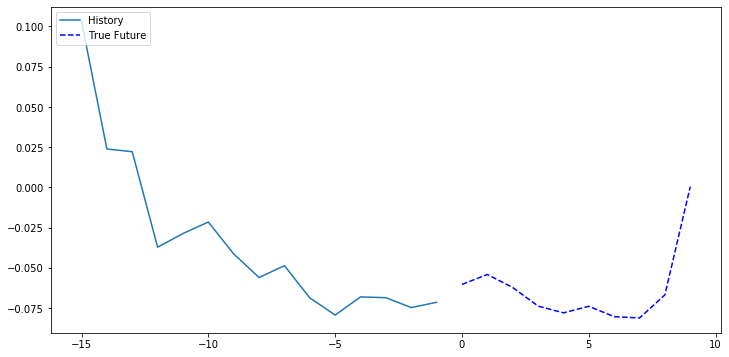

In [13]:
multi_step_plot(x_train_multi[0], y_train_multi[0].reshape(-1, 15), np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

In [14]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = 0.01
BATCH_SIZE=2048
save_path = "./trained_models_acc/multistep"
cur_file = "LSTM3_10steps_large" + "_pool"
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [15]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(256,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:], 
                                          activation = 'relu'))
multi_step_model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(128, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(y_train_multi.shape[-1]))

multi_step_model.compile(optimizer='nadam', loss='mae', metrics= ['mse', 'mae'])
multi_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           278528    
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 150)               19350     
Total params: 626,582
Trainable params: 626,582
Non-trainable params: 0
_________________________________________________________________


Let's see how the model predicts before it trains.

In [16]:
print(multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).shape)

(488950, 150)


In [17]:
EPOCHS = 30
multi_step_history = multi_step_model.fit(x_train_multi, y_train_multi, epochs=EPOCHS,
                                          validation_data=(x_val_multi, y_val_multi), 
                                          batch_size = BATCH_SIZE, callbacks=callback_list)

Train on 1754375 samples, validate on 488950 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.0667 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0667
Epoch 00001: val_loss improved from inf to 0.06604, saving model to ./trained_models_acc/multistep/LSTM3_10steps_large_pool.h5
1754375/1754375 [==============================] - 224s 128us/sample - loss: 0.0667 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0667 - val_loss: 0.0660 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0660
Epoch 2/30
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.0607 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0607
Epoch 00002: val_loss improved from 0.06604 to 0.06368, saving model to ./trained_models_acc/multistep/LSTM3_10steps_large_pool.h5
1754375/1754375 [==============================] - 223s 127us/sample - loss: 0.0607 - mean_squared_error: 0.0119 - mean_abso

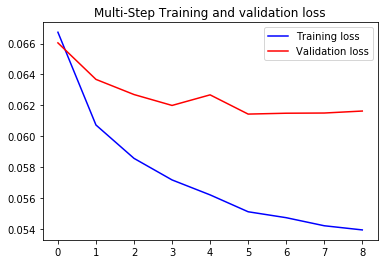

In [18]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

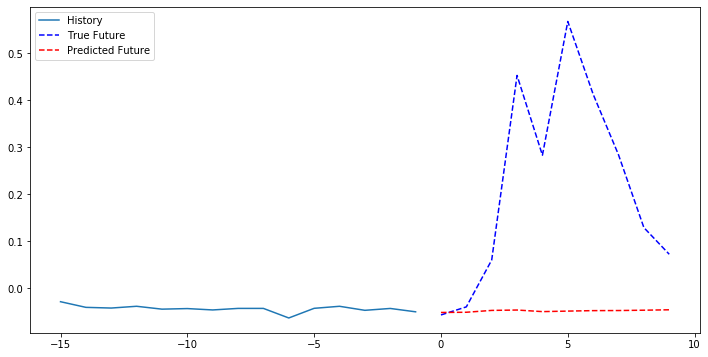

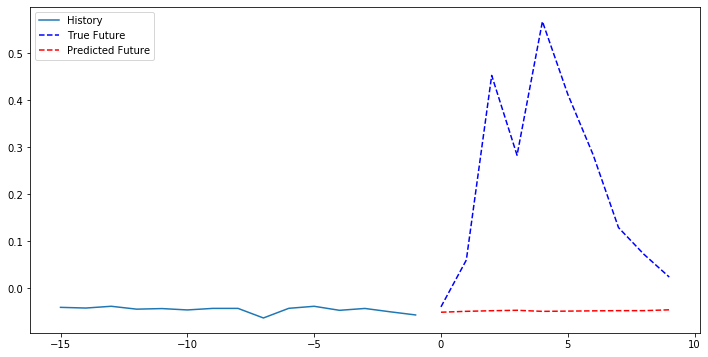

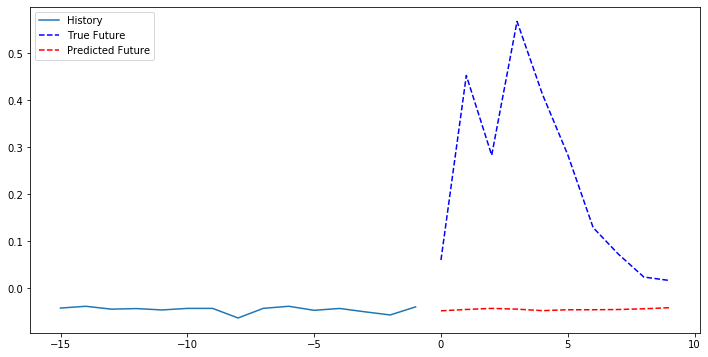

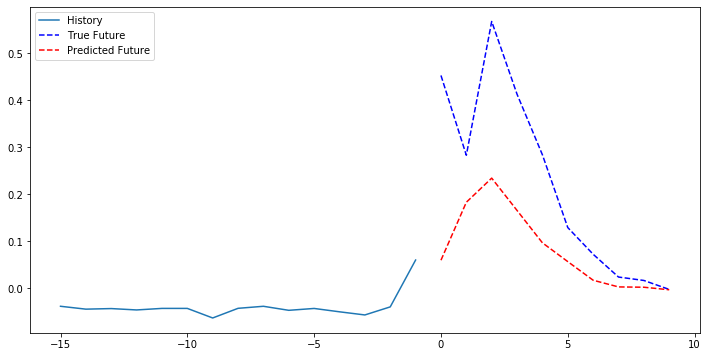

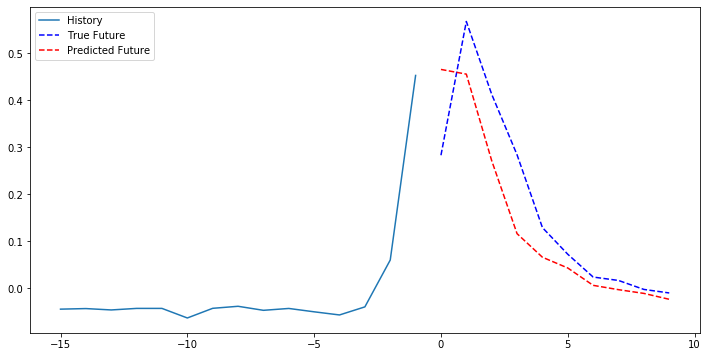

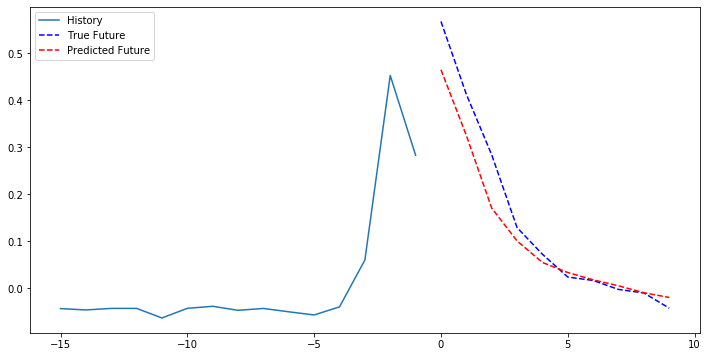

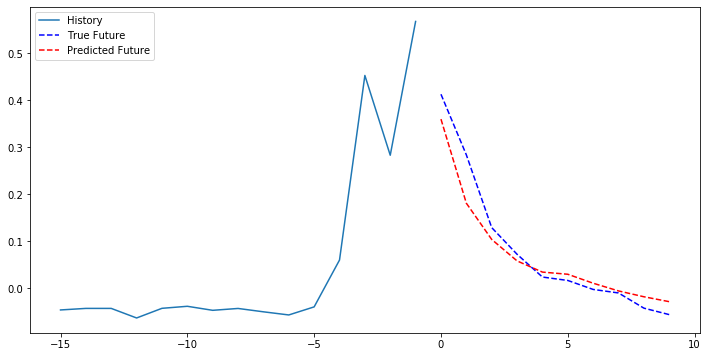

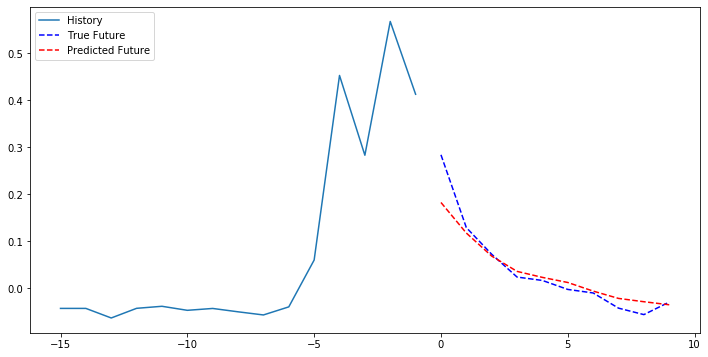

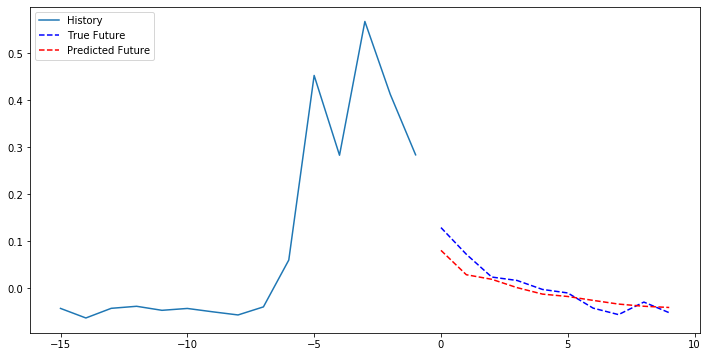

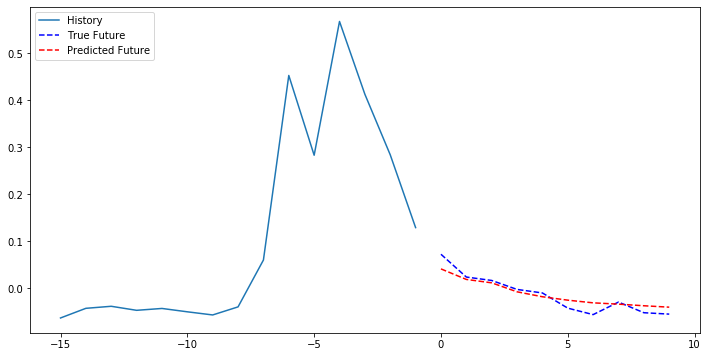

In [22]:
x = x_val_multi[:20]
y = y_val_multi[:20].reshape(len(x), -1, 15)
pred_y = multi_step_model.predict(x).reshape(len(x), -1, 15)
for i in range(10):
    multi_step_plot(x[i], y[i], pred_y[i])

In [50]:
pred_y = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(len(x_val_multi), -1, 15)
pred_y.shape

(285440, 5, 15)

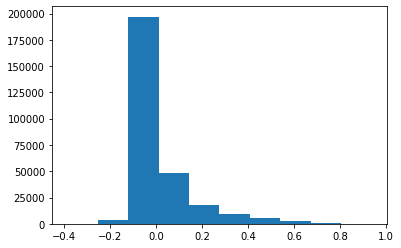

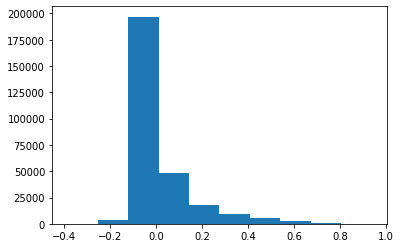

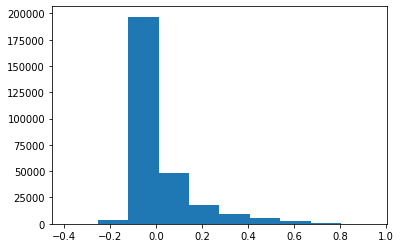

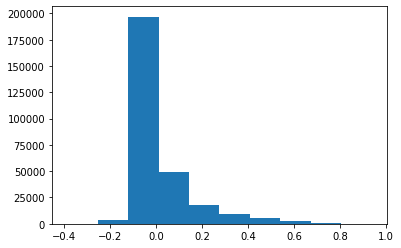

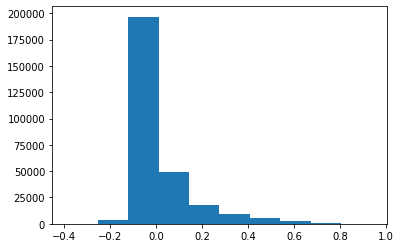

In [51]:
for i in range(5):
    plt.figure()
    data = x_val_multi[:, i, 0]
    data = data[data < 100]
    plt.hist(data)
    plt.show()

# Analyze the predictions of the model

In [52]:
y_pred = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_val_multi.reshape(-1)
y_pred.shape, y_true.shape

((21408000,), (21408000,))

In [53]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.40436054873364513
Max Error Score: 1.0508267626706946
Mean Absolute Error Score: 0.060649021552208804
Mean Squared Error Score: 0.011735154498687433
Median Absolute Error Score: 0.027691833251122965
R2 Score: 0.3872123834781652
